In [266]:
#!pip install yfinance

In [267]:
import yfinance as yf
import pandas as pd
import numpy as np

In [268]:
FEDFUNDS = pd.read_csv("RNN_Data/FEDFUNDS.csv")

In [269]:
FEDFUNDS.head()

,observation_date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [270]:
FEDFUNDS["observation_date"] = FEDFUNDS["observation_date"].str.replace("-", "")
FEDFUNDS.columns = ["Date", "FEDFUNDS"]
FEDFUNDS["Date"] = FEDFUNDS["Date"].str[:6]

In [271]:
# STOCK_GOOG = yf.Ticker("GOOG") # 주가 조회 도구
# STOCK_MSFT = yf.Ticker("MSFT") # 주가 조회 도구
# STOCK_AAPL = yf.Ticker("AAPL") # 주가 조회 도구
STOCK_TSLA = yf.Ticker("TSLA") # 주가 조회 도구
# STOCK_NVDA = yf.Ticker("NVDA") # 주가 조회 도구
#STOCK_5930 = yf.Ticker("005930.KS") # 주가 조회 도구
Stock1 = STOCK_TSLA.history(start = "2014-01-01", end = None)
#Stock2 = STOCK_5930.history(start = "2014-01-01", end = None)

In [272]:
Stock1 = Stock1.reset_index()

In [273]:
Stock1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2758 entries, 0 to 2757
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          2758 non-null   datetime64[ns, America/New_York]
 1   Open          2758 non-null   float64                         
 2   High          2758 non-null   float64                         
 3   Low           2758 non-null   float64                         
 4   Close         2758 non-null   float64                         
 5   Volume        2758 non-null   int64                           
 6   Dividends     2758 non-null   float64                         
 7   Stock Splits  2758 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 172.5 KB


In [274]:
Stock1["Date"] = Stock1["Date"].astype(str).str[:10]
Stock1["Date"] = Stock1["Date"].str.replace("-", "")
Stock1["NewDate"] = Stock1["Date"].str[:6]

In [275]:
Stock1.columns = ['Date_origin', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'NewDate']

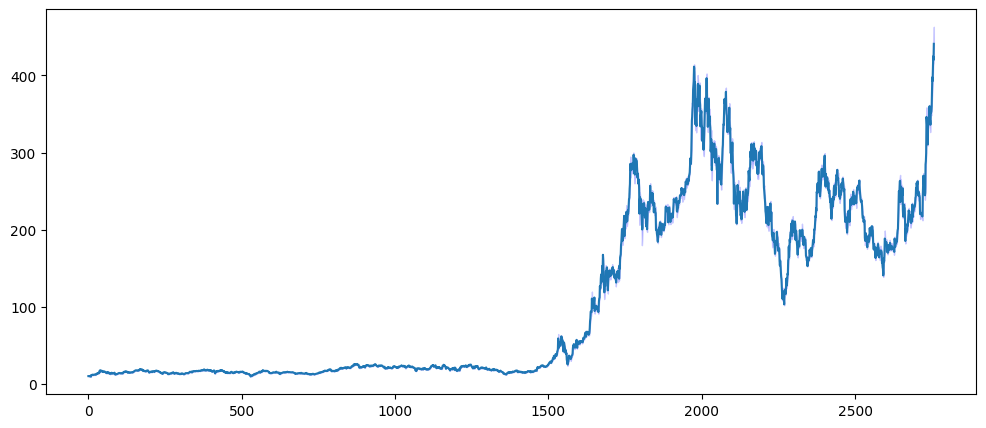

In [276]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(Stock1["Open"])
plt.fill_between(Stock1.index, Stock1["High"], Stock1["Low"], color='blue', alpha=0.2, label="High-Low Range")
plt.show()

In [277]:
import tensorflow as tf
from tensorflow import keras as tf_keras

In [278]:
Stock1.head(1)

,Date_origin,Open,High,Low,Close,Volume,Dividends,Stock Splits,NewDate
0,20140102,9.986667,10.165333,9.77,10.006667,92826000,0.0,0.0,201401


In [279]:
FEDFUNDS.head(3)

,Date,FEDFUNDS
0,195407,0.80
1,195408,1.22
2,195409,1.07


In [280]:
df = pd.merge(Stock1, FEDFUNDS, left_on="NewDate",right_on="Date", how="inner")

In [281]:
df.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date_origin   2747 non-null   object 
 1   Open          2747 non-null   float64
 2   High          2747 non-null   float64
 3   Low           2747 non-null   float64
 4   Close         2747 non-null   float64
 5   Volume        2747 non-null   int64  
 6   Dividends     2747 non-null   float64
 7   Stock Splits  2747 non-null   float64
 8   NewDate       2747 non-null   object 
 9   Date          2747 non-null   object 
 10  FEDFUNDS      2747 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 236.2+ KB


In [282]:
targets = df["Open"]
features = df[["Date_origin", "FEDFUNDS"]]


In [283]:
features["Date_origin"] = features["Date_origin"].astype(int)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date_origin  2747 non-null   int32  
 1   FEDFUNDS     2747 non-null   float64
dtypes: float64(1), int32(1)
memory usage: 32.3 KB


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6352\1069790655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["Date_origin"] = features["Date_origin"].astype(int)


In [284]:
features.head()

,Date_origin,FEDFUNDS
0,20140102,0.07
1,20140103,0.07
2,20140106,0.07
3,20140107,0.07
4,20140108,0.07


In [285]:
print(len(df) * 0.8)
print(len(df) * 0.8 * 0.8)

2197.6
1758.08


In [286]:
days = 30   # 얼마만큼을 하나의 묶음으로 볼건지
stride = 1  # 1-1, 2-1의 데이터의 차이 데이터 묶음간 얼마나 차이가 나게 할지
delay = 33 # 타겟값을 몇일 뒤로 할지

In [287]:
# 데이터 셋 만들기 2

datasets = []
for sidx, eidx in zip([0, 1800, 2200], [1800, 2200, None]):
  dataset = tf_keras.utils.timeseries_dataset_from_array(
    data=features[:-delay], # 전체 기간 중에서 마지막 11일치의 데이터는 제외
    targets=targets[delay:],
    sequence_length= days,
    sampling_rate=stride,
    start_index=sidx,
    end_index=eidx,
    batch_size=16,
    shuffle=False)
  datasets.append(dataset)

In [288]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#크게 영향은 없을거 같아서 포기

In [289]:
for i, dataset in enumerate(datasets):
    print(f"--- Dataset {i + 1} ---")
    for x, y in dataset:
        print("Features (X):", x[0])
        print("Targets (Y):", y[0])
        break  # 각 데이터셋에서 첫 배치만 출력

--- Dataset 1 ---
Features (X): tf.Tensor(
[[2.0140102e+07 7.0000000e-02]
 [2.0140103e+07 7.0000000e-02]
 [2.0140106e+07 7.0000000e-02]
 [2.0140107e+07 7.0000000e-02]
 [2.0140108e+07 7.0000000e-02]
 [2.0140109e+07 7.0000000e-02]
 [2.0140110e+07 7.0000000e-02]
 [2.0140113e+07 7.0000000e-02]
 [2.0140114e+07 7.0000000e-02]
 [2.0140115e+07 7.0000000e-02]
 [2.0140116e+07 7.0000000e-02]
 [2.0140117e+07 7.0000000e-02]
 [2.0140121e+07 7.0000000e-02]
 [2.0140122e+07 7.0000000e-02]
 [2.0140123e+07 7.0000000e-02]
 [2.0140124e+07 7.0000000e-02]
 [2.0140127e+07 7.0000000e-02]
 [2.0140128e+07 7.0000000e-02]
 [2.0140129e+07 7.0000000e-02]
 [2.0140130e+07 7.0000000e-02]
 [2.0140131e+07 7.0000000e-02]
 [2.0140203e+07 7.0000000e-02]
 [2.0140204e+07 7.0000000e-02]
 [2.0140205e+07 7.0000000e-02]
 [2.0140206e+07 7.0000000e-02]
 [2.0140207e+07 7.0000000e-02]
 [2.0140210e+07 7.0000000e-02]
 [2.0140211e+07 7.0000000e-02]
 [2.0140212e+07 7.0000000e-02]
 [2.0140213e+07 7.0000000e-02]], shape=(30, 2), dtype=floa

In [290]:
for X, y in datasets[0]:
  print(X.shape, y.shape)
  break

for X, y in datasets[0]:
  print(X.shape, y.shape)
  break

(16, 30, 2) (16,)
(16, 30, 2) (16,)


In [291]:
features

,Date_origin,FEDFUNDS
0,20140102,0.07
1,20140103,0.07
2,20140106,0.07
3,20140107,0.07
4,20140108,0.07
...,...,...
2742,20241122,4.64
2743,20241125,4.64
2744,20241126,4.64
2745,20241127,4.64


In [292]:
# 모델 구조 설계 3 : 순환 신경망 모델

input = tf_keras.layers.Input(shape=(30, 2))
x = tf_keras.layers.SimpleRNN(units=16)(input)
output = tf_keras.layers.Dense(units=1)(x)

model3 = tf_keras.models.Model(input, output)

model3.summary()

model3.compile(loss="mse", optimizer="adam", metrics='mae')

history03 = model3.fit(datasets[0], validation_batch_size=datasets[1], epochs=10)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 30, 2)]           0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 16)                304       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
111/111 [==============================] - 2s 4ms/step - loss: 3595.1780 - mae: 33.4233
Epoch 2/10
111/111 [==============================] - 1s 5ms/step - loss: 3500.9358 - mae: 31.6382
Epoch 3/10
111/111 [==============================] - 1s 5ms/step - loss: 3435.1150 - mae: 30.

In [293]:
# 모델 구조 설계 4 : LSTM

input = tf_keras.layers.Input(shape=(30, 2))
x = tf_keras.layers.LSTM(units=16)(input)
output = tf_keras.layers.Dense(units=1)(x)

model4 = tf_keras.models.Model(input, output)

model4.summary()

model4.compile(loss="mse", optimizer="adam", metrics='mae')

history04 = model3.fit(datasets[0], validation_batch_size=datasets[1], epochs=10)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 30, 2)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 16)                1216      
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1233 (4.82 KB)
Trainable params: 1233 (4.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
111/111 [==============================] - 1s 5ms/step - loss: 3054.8416 - mae: 23.4354
Epoch 2/10
111/111 [==============================] - 1s 5ms/step - loss: 3019.7087 - mae: 22.6746
Epoch 3/10
111/111 [==============================] - 1s 5ms/step - loss: 2986.7329 - mae: 2